# SUPER RESOLUTION BY EDSR WITH DIV2K DATASET



## Import lib & load dataset

In [ ]:
!nvidia-smi

Fri Apr 22 03:21:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import tensorflow_datasets as tfds
from keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
ds_train = tfds.load('div2k/unknown_x4',split='train[:75%]',as_supervised=True)
ds_valid = tfds.load('div2k/unknown_x4',split='train[75%:]',as_supervised=True)
ds_test = tfds.load('div2k/unknown_x4',split='validation',as_supervised=True)


EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_unknown_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_unknown_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/unknown_x4/2.0.0.incomplete0D5GMM/div2k-train.tfrecord


  0%|          | 0/800 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/unknown_x4/2.0.0.incomplete0D5GMM/div2k-validation.tfrecord


  0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/unknown_x4/2.0.0. Subsequent calls will reuse this data.


 *Dataset: DIV2K: 
 - Train: 800 sample
    + LR
    + HR 
    
- Valid: 100 sample:
    + LR
    + HR

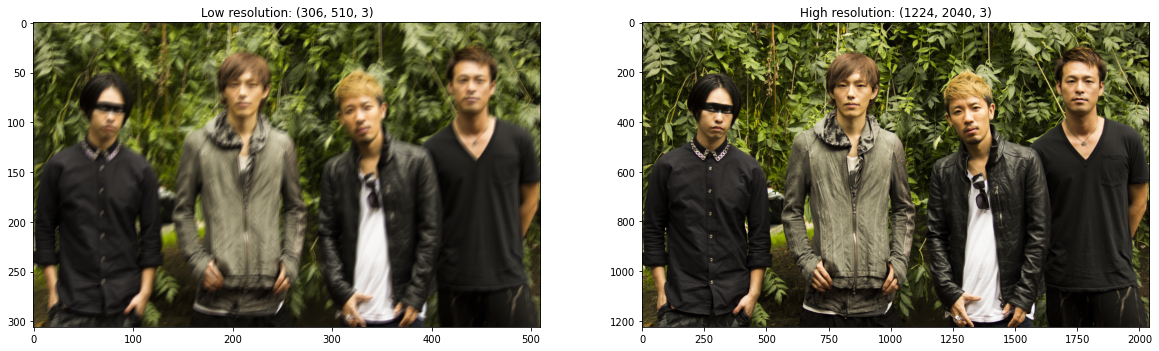

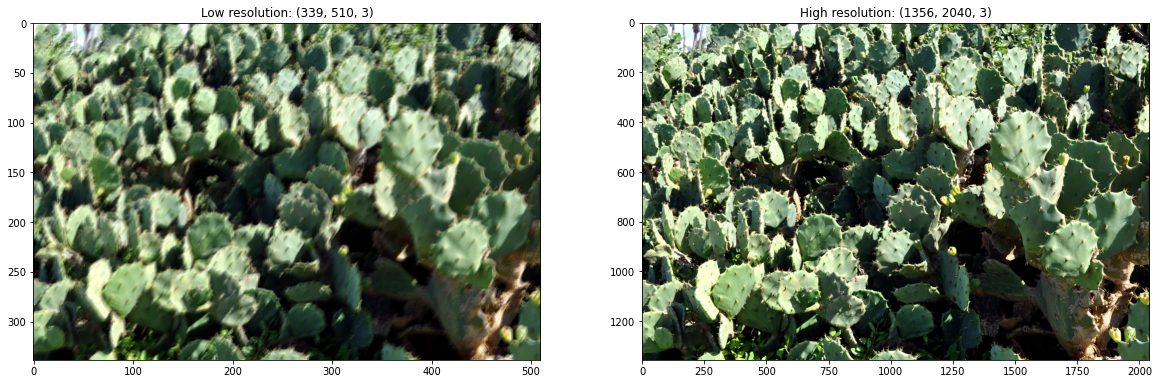

In [ ]:
for lr,hr in ds_train.take(2):
  plt.figure(figsize=(20,10))
  plt.subplot(1,2,1)
  plt.imshow(lr)
  plt.title('Low resolution: '+ str(lr.shape))
  plt.subplot(1,2,2)
  plt.imshow(hr)
  plt.title('High resolution: '+ str(hr.shape))

## Data Augmentation

In [ ]:
#Augmentation (crop, flip, rotate)

def rd_crop(lr_img, hr_img, hr_crop_size=96, scale=2):

    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

In [ ]:
def rd_flip(lr_img, hr_img):

    random = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(random < 0.5,lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))

In [ ]:
def rd_rotate(lr_img, hr_img):

    rd = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rd), tf.image.rot90(hr_img, rd)


### Preprocessing




In [ ]:
from tensorflow.data import AUTOTUNE
def preprocessing(data, batch_size=16,scale=4,repeat_count=None, random_transform=True):

        if random_transform:

            data = data.map(lambda lr, hr: rd_crop(lr, hr, scale=scale),num_parallel_calls=AUTOTUNE)

            data = data.map(rd_rotate,num_parallel_calls=AUTOTUNE)

            data = data.map(rd_flip,num_parallel_calls=AUTOTUNE)

        data = data.batch(batch_size)

        data = data.repeat(repeat_count)

        data = data.prefetch(buffer_size=AUTOTUNE)
        return data

In [ ]:
train = preprocessing(ds_train)
valid = preprocessing(ds_test,batch_size=1,repeat_count=1,random_transform=False)

test  = preprocessing(ds_test,batch_size=1,repeat_count=1,random_transform=False)


## Define Model 

In [ ]:
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda, UpSampling2D
from tensorflow.python.keras.models import Model



In [ ]:
def res_block(x_in, filters, scaling):
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

In [ ]:
def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

In [ ]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [ ]:
def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    # x = UpSampling2D((4,4),interpolation="nearest")(x)
    
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")

In [ ]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

## Training Model

In [ ]:
model=edsr(scale=4, num_filters=64, num_res_blocks=16, res_block_scaling=None)


In [ ]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=False,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False,
# )

In [ ]:
model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
_______________________________________________________________________________________________

In [ ]:
from tf.keras.optimizers import Adam
from tf.keras.callbacks import EarlyStopping,ModelCheckpoint

model.compile(optimizer= 'adam', loss = 'mse',metrics=[PSNR])
early = EarlyStopping(monitor = 'loss', patience = 3)
checkpoint = ModelCheckpoint("./content/drive/MyDrive/ai_prj/prj_Image Super-Resolution/checkpoint/edsr/cp.h5", monitor="loss", verbose=0, save_best_only=True,save_weight_only = True, mode="auto",)

In [ ]:
model.fit(train,validation_data=valid,epochs=100,verbose=True, callbacks=[early,checkpoint],steps_per_epoch=200)

Epoch 1/100
200/200 [==============================] - 243s 1s/step - loss: 448.0735 - PSNR: 25.4486 - val_loss: 353.6188 - val_PSNR: 23.7167
Epoch 2/100
200/200 [==============================] - 231s 1s/step - loss: 413.5029 - PSNR: 26.6515 - val_loss: 372.9904 - val_PSNR: 23.4599
Epoch 3/100
200/200 [==============================] - 229s 1s/step - loss: 420.2769 - PSNR: 26.1022 - val_loss: 304.6976 - val_PSNR: 24.4783
Epoch 4/100
200/200 [==============================] - 241s 1s/step - loss: 408.9865 - PSNR: 26.5948 - val_loss: 328.7140 - val_PSNR: 24.0855
Epoch 5/100
200/200 [==============================] - 231s 1s/step - loss: 414.4780 - PSNR: 26.4715 - val_loss: 322.7161 - val_PSNR: 24.2229
Epoch 6/100
200/200 [==============================] - 226s 1s/step - loss: 412.2662 - PSNR: 26.6079 - val_loss: 336.1993 - val_PSNR: 23.9782
Epoch 7/100
200/200 [==============================] - 245s 1s/step - loss: 422.2931 - PSNR: 25.9440 - val_loss: 333.9991 - val_PSNR: 24.0284


In [ ]:
model.save('/content/drive/MyDrive/ai_prj/prj_Image Super-Resolution/model/EDSR.h5')

## Histogram



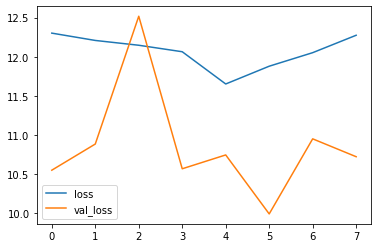

In [ ]:
loss = pd.DataFrame(model.history.history)
loss[['loss','val_loss']].plot()

In [ ]:
model.evaluate(test)

## Predict

In [ ]:
from PIL import Image
import cv2
def prepare_img(path,model):
# path = "/content/drive/MyDrive/ai_prj/Cinque_Terre_.jpeg"
  lr = np.array(Image.open(path).convert("RGB"))
  image = tf.expand_dims(lr, axis=0)
  image = tf.cast(image, tf.float32)
  sr = model(image)
  sr = tf.clip_by_value(sr, 0, 255)
  sr = tf.round(sr)
  sr = tf.cast(sr, tf.uint8)
  sr = np.array(sr)
  sr = np.squeeze(sr,axis=0)

  return lr,sr


# Random crop image
def rd_crop(lr_img, hr_img, hr_crop_size=96, scale=4):

    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_height = lr_height * scale
    hr_width = lr_width * scale


    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    iloc = np.array([[(lr_width,lr_height),(lr_width + lr_crop_size, lr_height+lr_crop_size)],[(hr_width,hr_height),(hr_width + hr_crop_size,hr_height+hr_crop_size)]])

    return lr_img_cropped, hr_img_cropped, iloc


def plot_result(path,model,hr_crop_size=96,scale =4 ):

  lr, sr = prepare_img(path,model)
  lr_c, sr_c , iloc= rd_crop(lr,sr,hr_crop_size)

  #fullsize
  plt.figure(figsize=(20,10))
  plt.subplot(1,2,1)
  out_lr = cv2.rectangle(lr.copy(),tuple(iloc[0,0]),tuple(iloc[0,1]),(255, 0, 0),2)
  plt.imshow(out_lr)
  plt.subplot(1,2,2)
  out_sr = cv2.rectangle(sr.copy(),tuple(iloc[1,0]),tuple(iloc[1,1]),(255, 0, 0),8)
  plt.imshow(out_sr)
  # print(tuple(iloc[0,1]),tuple(iloc[0,1]))


  #crop
  plt.figure(figsize=(20,10))
  plt.subplot(1,2,1)
  plt.imshow(lr_c)
  plt.title("Low-resolution")
  plt.subplot(1,2,2)
  plt.imshow(sr_c)
  plt.title("Super-resolution")

In [ ]:
path = "/content/drive/MyDrive/ai_prj/Cinque_Terre_.jpeg"
plot_result(path,model,hr_crop_size=120)


In [ ]:
path = "/content/drive/MyDrive/ai_prj/test.jpeg"
plot_result(path,model,hr_crop_size=120)
